# TOC entitlements near bus/rail lines
* Which bus/rail lines or rail stations have seen the most TOC entitlement activity?
* Which ones have seen lots of non-TOC entitlement activity? 

In [1]:
import functools
import contextily
import intake
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import utils
import boto3

In [2]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 20)

In [3]:
catalog = intake.open_catalog("../catalogs/*.yml")

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

## Assign entitlements to conditions

In [4]:
toc_tiers = utils.reconstruct_toc_tiers_file()

parcels = gpd.read_file(
    f"s3://{bucket_name}/gis/intermediate/toc_eligible_parcels_with_entitlements.geojson"
).to_crs({'init':'epsg:4326'})

In [5]:
toc_parcels = parcels[parcels.num_TOC > 0]

In [6]:
df = utils.parcels_join_toc_tiers(toc_parcels, toc_tiers)

## Which rule?

In [7]:
tier_1 = df[df.TOC_Tier == 1]
tier_2 = df[df.TOC_Tier == 2]
tier_3 = df[df.TOC_Tier == 3]
tier_4 = df[df.TOC_Tier == 4]

Text(0.6, -1.0, 'TOC Entitlements')

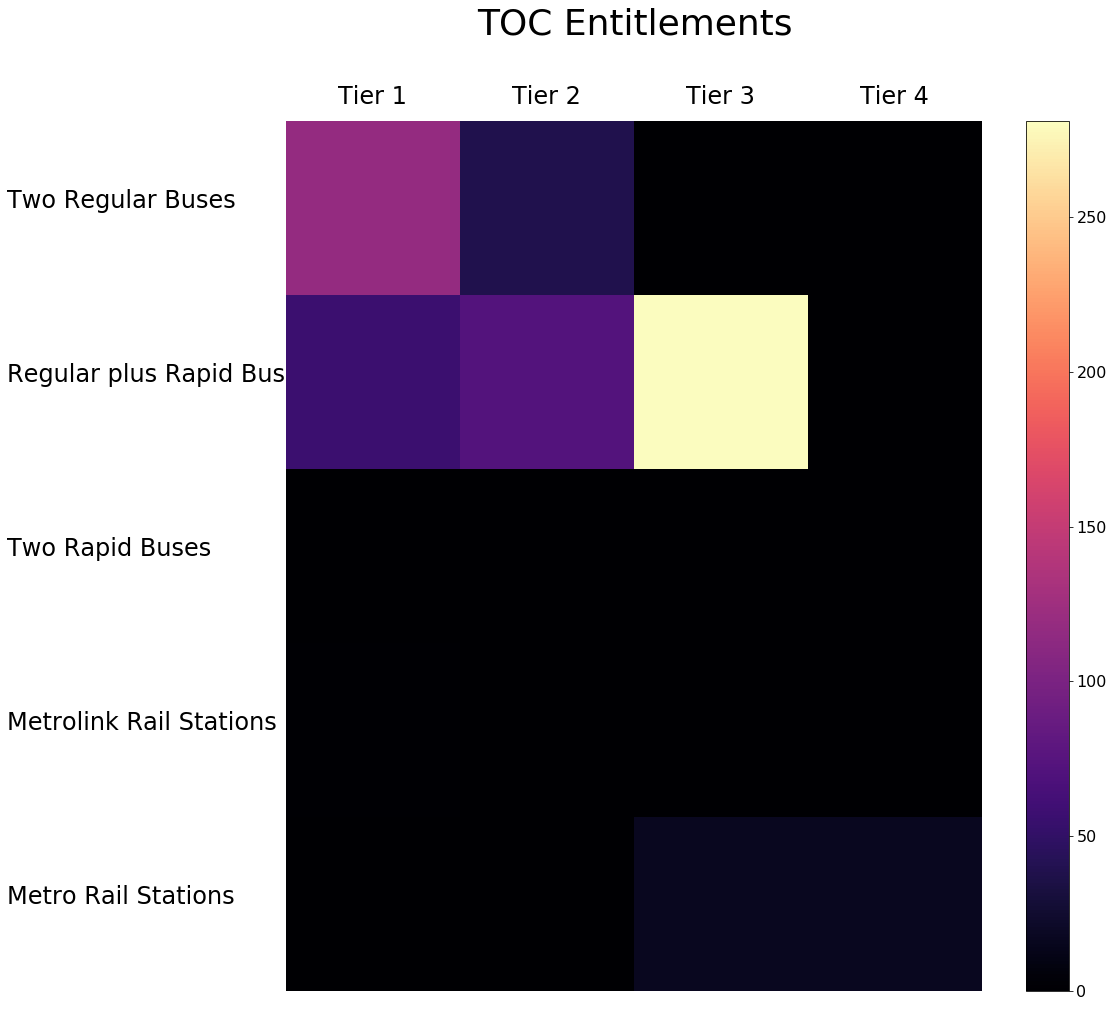

In [8]:
table = np.zeros(shape=(5, 4))
table[4,3] = tier_4[(tier_4.mode_a=="metro") & (tier_4.mode_b.isin(["metro", "bus"]))].num_TOC.sum()
table[4,2] = tier_4[tier_4.mode_a=="metro"].num_TOC.sum()
table[3,2] = tier_3[tier_3.mode_a=="metrolink"].num_TOC.sum()
table[3,1] = tier_2[tier_2.mode_a=="metrolink"].num_TOC.sum()
table[3,0] = tier_1[tier_1.mode_a=="metrolink"].num_TOC.sum()
table[2,2] = tier_3[tier_3.a_rapid & tier_3.b_rapid].num_TOC.sum()
table[2,1] = tier_2[tier_2.a_rapid & tier_2.b_rapid].num_TOC.sum()
table[1,2] = tier_3[tier_3.a_rapid ^ tier_3.b_rapid].num_TOC.sum()
table[1,1] = tier_2[tier_2.a_rapid ^ tier_2.b_rapid].num_TOC.sum()
table[1,0] = tier_1[tier_1.a_rapid ^ tier_1.b_rapid].num_TOC.sum()
table[0,1] = tier_2[~tier_2.a_rapid & ~tier_2.b_rapid].num_TOC.sum()
table[0,0] = tier_1[~tier_1.a_rapid & ~tier_1.b_rapid].num_TOC.sum()


fig, ax = plt.subplots(figsize=(16,16))
pos = ax.imshow(table, cmap="magma")
ax.set_axis_off()
ax.text(-2.1, 0.0, "Two Regular Buses", fontsize=24)
ax.text(-2.1, 1.0, "Regular plus Rapid Bus", fontsize=24)
ax.text(-2.1, 2.0, "Two Rapid Buses", fontsize=24)
ax.text(-2.1, 3.0, "Metrolink Rail Stations", fontsize=24)
ax.text(-2.1, 4.0, "Metro Rail Stations", fontsize=24)
ax.text(-0.2, -0.6, "Tier 1", fontsize=24)
ax.text(0.8, -0.6, "Tier 2", fontsize=24)
ax.text(1.8, -0.6, "Tier 3", fontsize=24)
ax.text(2.8, -0.6, "Tier 4", fontsize=24)
cb = fig.colorbar(pos, ax=ax)
cb.ax.tick_params(labelsize=16)
ax.text(0.6, -1.0, "TOC Entitlements", fontsize=36)
#plt.savefig("toc.png", bbox_inches='tight')

## By Tier and Line

In [9]:
def summarize(tier, header):
    display(Markdown(header))
    metro_rail_summary = (
        tier[tier.mode_a=="metro"].groupby(["station_name"])
        .agg({"num_TOC":"sum", "num_nonTOC":"sum"})
        .sort_values(['num_TOC', 'num_nonTOC'], ascending = [False, False])
    )
    if len(metro_rail_summary):
        display(Markdown("#### Metro Rail"))
        display(metro_rail_summary)
    
    metrolink_summary = (
        tier[tier.mode_a=="metrolink"].groupby("station_name")
        .agg({"num_TOC":"sum", "num_nonTOC":"sum"})
        .sort_values(['num_TOC', 'num_nonTOC'], ascending = [False, False])

    )
    metrolink_summary = metrolink_summary.reindex(
        index=metrolink_summary.index.rename("station_name")
    )
    if len(metrolink_summary):
        display(Markdown("#### Metrolink"))
        display(metrolink_summary)
    
    a = tier[tier.mode_a=="bus"].groupby("line_name_a").agg({"num_TOC":"sum", "num_nonTOC":"sum"})
    b = tier[tier.mode_b=="bus"].groupby("line_name_b").agg({"num_TOC":"sum", "num_nonTOC":"sum"})
    bus_summary = (
        a.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int") + 
        b.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int")
    )
    if len(bus_summary):
        display(Markdown("#### Bus Lines"))
        display(bus_summary.sort_values(["num_TOC", "num_nonTOC"], ascending=[False, False]).head(60))

In [10]:
# TODO: Figure out a better deduplicating strategy.
summarize(tier_1.drop_duplicates(subset=["AIN"]), "## Tier 1 Statistics")
summarize(tier_2.drop_duplicates(subset=["AIN"]), "## Tier 2 Statistics")
summarize(tier_3.drop_duplicates(subset=["AIN"]), "## Tier 3 Statistics")
summarize(tier_4.drop_duplicates(subset=["AIN"]), "## Tier 4 Statistics")

## Tier 1 Statistics

#### Bus Lines

,num_TOC,num_nonTOC
Bus Route,,
4,12,2
704,7,2
2/302,5,0
14/37,4,0
224,4,0
233,4,0
152/353,3,0
754,3,0
163/162,2,0


## Tier 2 Statistics

#### Bus Lines

,num_TOC,num_nonTOC
Bus Route,,
728,11,0
33,10,0
206,9,0
R12,9,0
204,8,0
754,8,0
704,5,0
4,4,0
757,4,0


## Tier 3 Statistics

#### Metro Rail

,num_TOC,num_nonTOC
station_name,,
Westlake / MacArthur Park Station,10,0
Wilshire / Normandie Station,9,0
Wilshire / Vermont Station,8,2
North Hollywood Station,7,0
Florence/Hindry,5,0
Vermont / Sunset Station,4,0
Expo / Bundy Station,3,0
Pico / Aliso Station,3,0
Vermont / Beverly Station,3,0


#### Bus Lines

,num_TOC,num_nonTOC
Bus Route,,
720,32,3
757,15,7
704,15,0
754,13,0
4,12,0
217,9,0
780,9,0
901,7,0
33,6,5


## Tier 4 Statistics

#### Metro Rail

,num_TOC,num_nonTOC
station_name,,
Vermont / Santa Monica Station,3,3
Vermont / Sunset Station,3,0
Wilshire / Western Station,2,1
Wilshire / Normandie Station,1,1
Hollywood / Highland Station,1,0


#### Bus Lines

,num_TOC,num_nonTOC
Bus Route,,
704,3,3
754,3,0
710,2,1
720,1,1
780,1,0


## By Line

In [11]:
def summarize(df):
    # Bus
    bus_df = df[(df.mode_a == "bus") | (df.mode_b == "bus")]

    a = bus_df[bus_df.mode_a=="bus"].groupby("line_name_a").agg({"num_TOC":"sum"})
    b = bus_df[bus_df.mode_b=="bus"].groupby("line_name_b").agg({"num_TOC":"sum"})
    bus_summary = (
        a.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int") + 
        b.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int")
    )

    if len(bus_summary):
        display(Markdown("#### Bus Lines"))
        display(bus_summary.sort_values(["num_TOC"], ascending = False).head(60))
      
    # Metrolink
    metrolink_df = df[df.mode_a == "metrolink"]
    
    metrolink_summary = (
        metrolink_df.groupby("line_name_a")
        .agg({"num_TOC": "sum"})
        .sort_values(["num_TOC"], ascending = False)
    )
    
    if len(metrolink_summary):
        display(Markdown("#### Metrolink"))
        display(metrolink_summary)

    # Metro Rail
    metro_df = df[(df.mode_a == "metro") | (df.mode_b == "metro")]

    metro_rail_summary = (
        metro_df.groupby("line_name_a")
        .agg({"num_TOC":"sum"})
        .sort_values(["num_TOC"], ascending = False)
    )
    
    if len(metro_rail_summary):
        display(Markdown("#### Metro Rail"))
        display(metro_rail_summary)

In [12]:
summarize(df)

#### Bus Lines

,num_TOC
Bus Route,
4,86
704,78
754,77
757,60
720,60
780,41
207,35
728,33
204,30


#### Metrolink

,num_TOC
line_name_a,
Ventura County Metrolink Line,2


#### Metro Rail

,num_TOC
line_name_a,
Purple,76
Red,56
Red/Purple,36
Crenshaw,12
Gold,11
EXPO,9
Blue,1
Blue/EXPO,1
